In [3]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

import tensorflow as tf

import pandas as pd

In [4]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, GRU, LSTM, TimeDistributed

from attention import Attention

# 处理数据

In [5]:
fname_train = '../data/train-HAN.pkl'
fname_test = '../data/test-HAN.pkl'

with open(fname_train, 'rb') as inp:
    word2id = pickle.load(inp)
    id2word = pickle.load(inp)
    relation2id = pickle.load(inp)
    entity2id = pickle.load(inp)
    train = pickle.load(inp)
    labels = pickle.load(inp)
    position1 = pickle.load(inp)
    position2 = pickle.load(inp)
    E = pickle.load(inp)

with open(fname_test, 'rb') as inp:
    test = pickle.load(inp)
    labels_t = pickle.load(inp)
    position1_t = pickle.load(inp)
    position2_t = pickle.load(inp)
    E_t = pickle.load(inp)

print("train len", len(train))
print("test len", len(test))
print("word2id len", len(word2id))


labels = np.array(pd.get_dummies(labels))

train len 2064
test len 688
word2id len 561


# 模型

In [11]:
class HAN(Model):
    def __init__(self,
                 MAX_WORD_NUM = 20,
                 MAX_SEN_NUM = 20,
                 EMBEDDING_DIM = 200,
                 class_num = 6,
                 last_activation='softmax'):
        super(HAN, self).__init__()
        self.MAX_WORD_NUM = MAX_WORD_NUM
        self.MAX_SEN_NUM = MAX_SEN_NUM
        self.EMBEDDING_DIM = EMBEDDING_DIM
        self.class_num = class_num
        self.last_activation = last_activation

        
        
        sequence_input = Input(shape=(self.MAX_WORD_NUM,), dtype='int32')
        pos1_input = Input(shape=(self.MAX_SEN_NUM,self.MAX_WORD_NUM,), dtype='int32')
        pos2_input = Input(shape=(self.MAX_SEN_NUM,self.MAX_WORD_NUM,), dtype='int32')
        e_input = Input(shape=(self.MAX_SEN_NUM,self.MAX_WORD_NUM,), dtype='int32')

        embedding_matrix = np.random.random((len(word2id) + 1, self.EMBEDDING_DIM))
        for word, i in word2id.items():
            embedding_vector = word2id[word]
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
                
        word_embeds = Embedding(len(word2id) + 1,
                            self.EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length = self.MAX_WORD_NUM,
                            trainable=True)        
        # 文档特征##################################################
        # Word part##############
        word_embedding = word_embeds(sequence_input)
        #print("word_embedding:",word_embedding.shape)##
        
        word_embedding = Bidirectional(LSTM(64, return_sequences=True))(word_embedding)
        #print("word_embedding:",word_embedding.shape)##
        word_emb = Attention(self.MAX_WORD_NUM)(word_embedding)
        #print("word_embedding:",word_emb.shape)##
        wordEncoder = Model(sequence_input, word_emb)
        # Sentence part
        self.sen_encoder = TimeDistributed(wordEncoder)#(sentence_input)
        self.sen_embedding = Bidirectional(LSTM(128, return_sequences=True))#(sen_encoder)
        self.sen_emb = Attention(self.MAX_SEN_NUM)#(sen_embedding)##
        
        
        # pos1
        #print("pos1_input",pos1_input.shape)##
        self.pos1_f = Bidirectional(LSTM(64, return_sequences=True))#(pos1_input)
        self.pos1_emb = Attention(self.MAX_SEN_NUM)#(pos1)
        
        
        # pos2
        #print("pos2_input",pos2_input.shape)##
        self.pos2_f = Bidirectional(LSTM(64, return_sequences=True))#(pos1_input)
        self.pos2_emb = Attention(self.MAX_SEN_NUM)#(pos1)
       

        #e
        #print("e_input",e_input.shape)##
        self.e_f = Bidirectional(LSTM(64, return_sequences=True))#(pos1_input)
        self.e_emb = Attention(self.MAX_SEN_NUM)#(pos1)
       

        self.feature = Dense(64)#(feature)

        self.preds = Dense(class_num, activation=self.last_activation)#(feature)

    def call(self, inputs):

        x_sentence = self.sen_encoder(inputs[0])
        x_sentence = self.sen_embedding(x_sentence)  
        x_sentence = self.sen_emb(x_sentence)
        #print("x_sentence",x_sentence)##
        
        pos1_input = tf.cast(inputs[1], tf.float32)
        x_pos1 = self.pos1_f(pos1_input)
        x_pos1 = self.pos1_emb(x_pos1)
        #print("x_pos1",x_pos1)##
        
         
        pos2_input = tf.cast(inputs[2], tf.float32)
        x_pos2 = self.pos2_f(pos2_input)
        x_pos2 = self.pos2_emb(x_pos2)
        #print("x_pos2",x_pos2)##
        
        
        e_input = tf.cast(inputs[3], tf.float32)
        x_e = self.e_f(e_input)
        x_e = self.e_emb(x_e)
        #print("x_e",x_e)##
        
        
        x_feature = tf.concat([x_sentence,x_pos1,x_pos2,x_e], 1)
        #print("x_feature:",x_feature)##
        x_feature = self.feature(x_feature)
        #print("x_feature:",x_feature)##
        
        output = self.preds(x_feature)
        
        return output

In [12]:
print(train.shape)
print(position1.shape)
print(position2.shape)
print(E.shape)
print(labels.shape)

(2064, 20, 20)
(2064, 20, 20)
(2064, 20, 20)
(2064, 20, 20)
(2064, 6)


In [14]:
model = HAN()
model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['acc'])

cp = ModelCheckpoint('model.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history = model.fit([train,position1,position2,E],labels,batch_size=64,epochs=50,callbacks=[cp])


Epoch 1/50
33/33 [==============================] - 44s 619ms/step - loss: 1.3943 - acc: 0.4169
Epoch 2/50
33/33 [==============================] - 19s 574ms/step - loss: 0.8812 - acc: 0.6560
Epoch 3/50
33/33 [==============================] - 19s 573ms/step - loss: 0.6800 - acc: 0.7477
Epoch 4/50
33/33 [==============================] - 19s 564ms/step - loss: 0.5333 - acc: 0.8063
Epoch 5/50
33/33 [==============================] - 19s 565ms/step - loss: 0.4467 - acc: 0.8483
Epoch 6/50
33/33 [==============================] - 18s 559ms/step - loss: 0.4161 - acc: 0.8359
Epoch 7/50
33/33 [==============================] - 19s 563ms/step - loss: 0.3527 - acc: 0.8749
Epoch 8/50
33/33 [==============================] - 19s 585ms/step - loss: 0.3369 - acc: 0.8679
Epoch 9/50
33/33 [==============================] - 19s 568ms/step - loss: 0.3176 - acc: 0.8719
Epoch 10/50
33/33 [==============================] - 19s 565ms/step - loss: 0.3325 - acc: 0.8645
Epoch 11/50
33/33 [====================

Epoch 48/50
33/33 [==============================] - 19s 572ms/step - loss: 0.1504 - acc: 0.9270
Epoch 49/50
33/33 [==============================] - 19s 573ms/step - loss: 0.1712 - acc: 0.9030
Epoch 50/50
33/33 [==============================] - 19s 568ms/step - loss: 0.1658 - acc: 0.9104


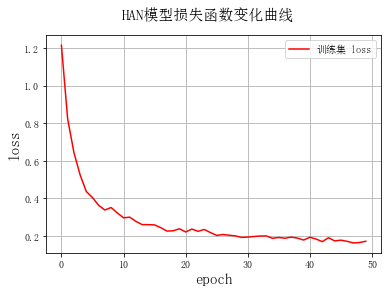

In [15]:
plt.rcParams['font.sans-serif']=['simsun'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

fig, ax = plt.subplots()#创建一个figure 
ax.plot(history.history['loss'], '-r', label='训练集 loss')

####打开网格
ax.grid(True)

####定义x, y轴的名称
ax.set_xlabel('epoch',fontsize=15)
ax.set_ylabel('loss',fontsize=15)

####定义标题
fig.suptitle('HAN模型损失函数变化曲线',fontsize=15)

####展示图例 legend loc=是用来定义图例的位置的，还有很多选择，大家可以自己尝试
ax.legend(loc = 'upper right')

plt.savefig("HAN模型损失函数变化曲线.png")

In [16]:
pred_test = model.predict([test,position1_t,position2_t,E_t])

In [17]:
result_ls = []
for i in pred_test:
    res = max(list(i))
    idx = list(i).index(res)
    result_ls.append(idx)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(labels_t,result_ls,digits = 4))

              precision    recall  f1-score   support

           0     0.8586    0.9291    0.8925       268
           1     0.8472    0.8971    0.8714        68
           2     0.7778    0.8485    0.8116        33
           3     0.8889    0.8000    0.8421        50
           4     0.9348    0.8600    0.8958        50
           5     0.8945    0.8128    0.8517       219

    accuracy                         0.8706       688
   macro avg     0.8670    0.8579    0.8609       688
weighted avg     0.8728    0.8706    0.8701       688

